In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def activation(x):
  act = 1/(1 + np.exp(-x))
  return act

def d_activation(x):
  d_act = x * (1 - x)
  return d_act

In [3]:
def get_delta_w(gradient,m,v,step):
    '''ADAM optimizer'''
    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 1e-8
    m = beta_1 * m + (1 - beta_1) * gradient
    v = beta_2 * v + (1 - beta_2) * gradient**2
    m_hat = m / (1 - beta_1**step)
    v_hat = v / (1 - beta_2**step)
    delta_w = m_hat / (np.sqrt(v_hat) + epsilon)
    #print(delta_w)
    return delta_w, m, v

In [4]:
def predict(Xp, wih, who):
  N = len(Xp)
  Xih = wih @ Xp.T
  yh = activation(Xih)
  yh = np.concatenate((np.ones((1,N)), yh))
  y_predicted = who @ yh

  return y_predicted

In [5]:
def get_L2(X, y, wih, who):
  N = len(X)
  ones = np.ones(N)
  Xp = np.c_[ones,X]
  y_predicted = predict(Xp, wih, who)
  error = y - y_predicted
  L2 = 0.5*np.mean(error**2)
  
  return L2

In [39]:
X_and_y = [(0, 1), (1, 3), (2, 2), (3, 5), (4, 7), (5, 8), (6, 8), (7, 9), (8, 10), (9, 12)]
data = pd.DataFrame(X_and_y, columns=['X','y'])
pick = np.array([True, True, True, True, True, False, True, True, False, True])

train = data[pick]
X = 6*train['X']/9 - 3
y = train['y'].values/12
# because we copied the data, we just rename X_train to X to avoid confusion
# NN on such a simple data set is uncommon, so this is unique

validation = data[~pick]
X_val = 6*validation['X']/9 -3
y_val = validation['y'].values/12

N = len(X)
ones = np.ones(N)
Xp = np.c_[ones,X]

np.random.seed(0)
input_nodes = 1
hidden_nodes = 10
output_nodes = 1
wih = 2 * np.random.rand(hidden_nodes,input_nodes + 1) - 1
who = 2 * np.random.rand(output_nodes,hidden_nodes + 1) - 1

mho = vho = mih = vih = 0. # initialize momenta and velocities

L2_train_list = []
L2_val_list = []
epoch_list = []

# THESE ARE ALL HYPERPARAMETERS
# we have to optimizer these numbers
epochs = 15000
learning_rate = 0.001
wd = 0.0 #0.001
drop = 0.001

for epoch in range(epochs):
  # forward propagation
  Xih = wih @ Xp.T
  yh = activation(Xih)

  dropout = np.random.rand(yh.shape[0], yh.shape[1]) < (1 - drop)
  dropout = dropout/(1 - drop)
  yh *= dropout

  yh = np.concatenate((np.ones((1,N)), yh))
  y_predicted = who @ yh
  # we eliminate y_predicted = act(Xho)
  
  # backpropagation
  error = y - y_predicted
  error_hidden = error.T @ who[:,1:]

  gradient_ho = -(1/N) * error @ yh.T
  # we also eliminate dact(y_pred) times the error
  gradient_ih = -(1/N) * (error_hidden.T * d_activation(yh[1:,:])) @ Xp

  gradient_ho += wd * (1/N) * who
  gradient_ih += wd * (1/N) * wih
  # here is weight decay in action

  delta_who, mho, vho = get_delta_w(gradient_ho, mho, vho, epoch+1)
  delta_wih, mih, vih = get_delta_w(gradient_ih, mih, vih, epoch+1)

  who = who - learning_rate * delta_who
  wih = wih - learning_rate * delta_wih
  
  if epoch%(epochs/100) == 0:
    L2 = 0.5*np.mean(error**2)
    L2_train_list.append(L2)
    epoch_list.append(epoch)
    L2_val = get_L2(X_val, y_val, wih, who)
    L2_val_list.append(L2_val)
  if epoch%(epochs/10) == 0:
    print(epoch,L2)

0 0.17197566061443226
1500 0.0022009318857468974
3000 0.0017686755593290145
4500 0.0013899334509867081
6000 0.0010473503253990055
7500 0.0008356857079315763
9000 0.0007760544735455652
10500 0.003816463195139596
12000 0.000714544948112699
13500 0.0006899656650718933


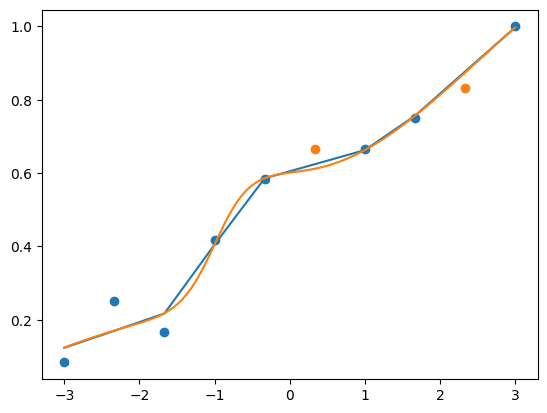

In [40]:
plt.scatter(X, y)
plt.scatter(X_val, y_val)
plt.plot(X, y_predicted[0])

x = np.linspace(-3, 3, 100)
xp = np.c_[np.ones(100),x]
y_pred_val = predict(xp, wih, who)
plt.plot(x, y_pred_val[0])

(0.0, 14850.0, 0.0, 0.004)

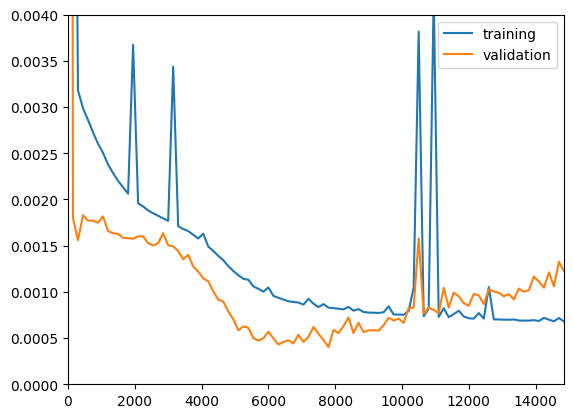

In [41]:
plt.plot(epoch_list, L2_train_list, label='training')
plt.plot(epoch_list, L2_val_list, label='validation')
plt.legend()
plt.axis((0, max(epoch_list), 0, (0.004)))

###L2 Regularization or Weight Decay###
$L2 = 0.5error^2 + 0.5a w ^2$

$dL2/dw = error + aw$

L2 can be kept small by either keeping error small or weights small. When the gradient is calculated, the weights are included. We include an alpha for "weight decay factor" as some hyper parameter that can be adjusted.

some weights end up being quite large, not between -1 and 1
to prevent overfitting, we need to prevent large weight values
adjusting this in backpropagation keeps the minimums of both together